## 概要
webで公開されているデータセットを用いて、実際に機械学習を行う。  
実際に行う中で、多分類問題での前処理やパラメータチューニングについて理解する。  
## 環境  
Python 3.9.5  
Jupyter Notebook
## 使用したデータセット
winequality データセット

In [14]:
with open("../DataSet/winequality.names") as f:
    print(f.read())     ## 使うデータセットの説明を表示する。

Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 016

In [15]:
## 読み込んだデータセットを確認する。
import pandas as pd
df = pd.read_csv("../DataSet/winequality-red.csv", ";")
print(type(df))
print(df.shape)
df.head()

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [16]:
df.describe()   ## 基本統計量を確認する。

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

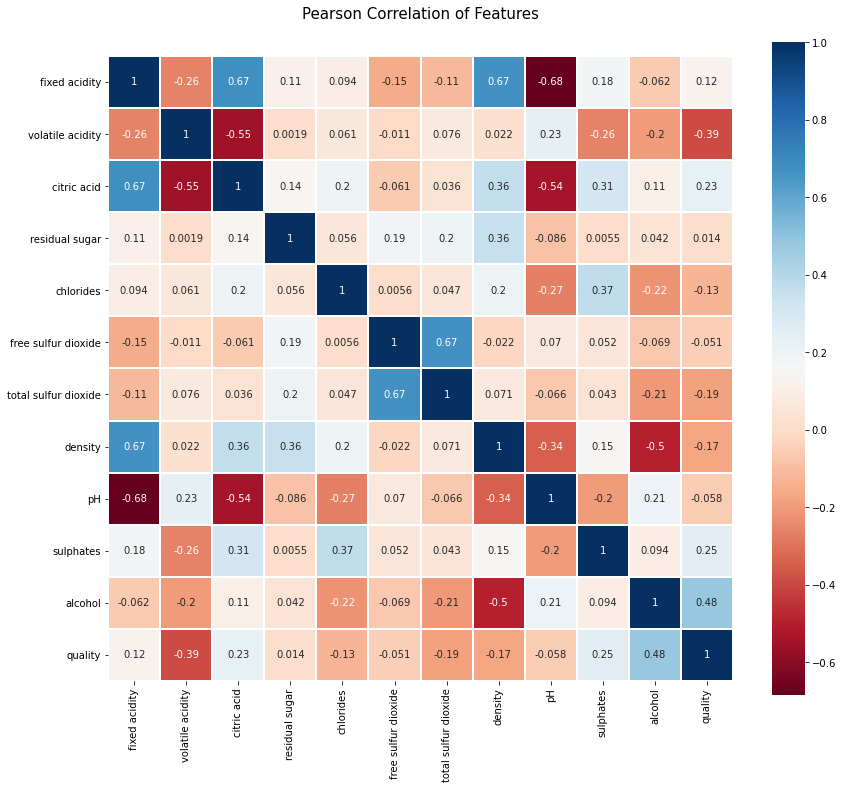

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
## 相関行列のヒートマップ。
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [18]:
from sklearn.svm import SVC
## 説明変数Xと目的変数Yに分ける.
x = df.drop("quality", axis=1)
y = df["quality"]

## 比較のため何もしないで学習.　アルゴリズムは後述.
model = SVC()
model.fit(x, y)
print("score:",model.score(x, y))

score: 0.5103189493433395


## 前処理
- データを可視化したところ、欠損値はなく、データのスケールがバラバラで、相関の高いデータが多いことがわかる。
    - そこで、データのスケールを揃え、次元削減を行う。  
- 正規化はデータの外れ値に大きく影響され、範囲を定める特別な理由がないため標準化を選択。  
- 次元削減では、本来は何度も試行錯誤を行うものだが、とても時間がかかる。  
    - そこで今回は相関行列のヒートマップを参考に、以下の特徴量を削除する。  
    1 - fixed acidity   
    3 - citric acid   
    7 - total sulfur dioxide   
    8 - density

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
## 次元削減
x.drop(["fixed acidity", "citric acid", "total sulfur dioxide", "density"], axis=1, inplace=True)
## 標準化
stdsc = StandardScaler()
x_std = stdsc.fit_transform(x)

## 学習アルゴリズムを決める
- 今回は多クラス分類かつ、不均衡でないデータを扱う。
    - 機械学習アルゴリズムは、SVMが良い結果が出たと説明にあるのでSVMを選択。
    - 評価関数は F1_micro または roc_auc_ovr がこの場合良い。そのため F1_micro を選択。
        - 多分類問題では、F値を計算するF1_scoreを利用するのが良い。
    - クロスバリデーション手法は KFold を行う。
        - データの偏りなどがあると別の手法で行う。

In [20]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

model = SVC()   ## SVM分類用インスタンス
cv = KFold(n_splits=5, shuffle=True, random_state=42)   ## クロスバリデーション
scoring = 'f1_micro'  # 評価指標をf1_microに指定
scores = cross_val_score(model, x_std, y, cv=cv, scoring=scoring, n_jobs=-1)    ## クロスバリデーションで評価指標算出
print(f'scores: {scores}')
print(f'average_score: {np.mean(scores)}')

scores: [0.6        0.59375    0.584375   0.6125     0.68338558]
average_score: 0.6148021159874608


## パラメータ調整を行う
- SVMのgammaとCの2種類のパラメータをチューニングする。
    - 適当な初期範囲を定めて検証曲線をプロットし、その結果に基づいて範囲を調整する。

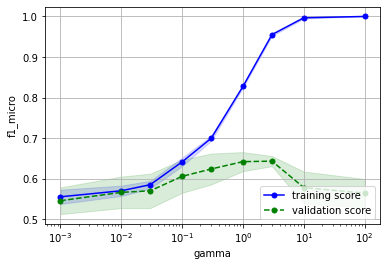

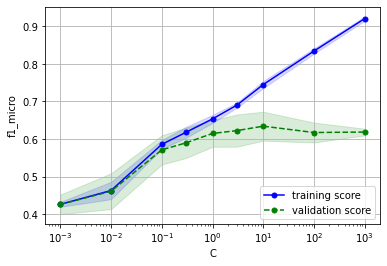

In [21]:
from sklearn.model_selection import validation_curve

cv_params = {"gamma": [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 100],
             "C": [0.001, 0.01, 0.1, 0.3, 1, 3, 10, 100, 1000]}
## 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model, X=x_std, y=y, param_name=k,
                                                 param_range=v, cv=cv, scoring=scoring, n_jobs=-1)
    ## 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    ## テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    ## training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    ## validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    ## スケールを'log'に（線形なパラメータは'linear'にするので注意）
    plt.xscale('log')
    ## 軸ラベルおよび凡例の指定
    plt.xlabel(k)  ## パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  ## スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  ## 凡例
    plt.grid()  ## グリッドを表示
    plt.show()  ## グラフを描画

- この、学習・検証データの性能が低いのが未学習、検証データの性能のみが下がっていくのが過学習である。
    - "gamma"は明らかに3からが過学習。
    - "C"は横這いで判断しにくいが、10からを過学習と扱うことにする。
- 今回は以下の範囲でパラメータを調整していく。
    - "gamma"：0.1～3
    - "C"：0.1～10

In [22]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

## パラメータの密度をグリッドサーチのときより増やす
li_g = np.logspace(0.1,3,15)
li_c = np.logspace(0.1,10,15)
cv_params = {'gamma': li_g, 'C': li_c}
## ランダムサーチのインスタンス作成
randcv = RandomizedSearchCV(model, cv_params, cv=cv, scoring=scoring, random_state=42, n_iter=50, n_jobs=-1)
## ランダムサーチ実行（学習実行）
randcv.fit(x_std, y)
## 最適パラメータの表示と保持
best_params = randcv.best_params_
best_score = randcv.best_score_
print(f'最適パラメータ: {best_params}\nscore: {best_score}')

最適パラメータ: {'gamma': 2.028349816662018, 'C': 6.414205312236928}
score: 0.6479173197492163


## まとめ
実際に機械学習の流れを winequality データセットを学習させることによって学ぶことができた。  
- 学習の結果は途中結果を含めて以下の通りである。  
    - そのまま学習させた場合  
    score: 0.5103189493433395  
    - 前処理のみ   
    score: 0.6148021159874608  
    - パラメータチューニング  
    最適パラメータ {'gamma': 2.028349816662018, 'C': 6.414205312236928}  
    score: 0.6479173197492163  
    
思ったよりも、前処理やパラメータチューニングで大きな差が出る。正しい方法でこれらを行う大切さを知った。

## 参考文献
https://qiita.com/Saku731/items/61b629fe608ede59a3f5  
https://qiita.com/c60evaporator/items/ca7eb70e1508d2ba5359  